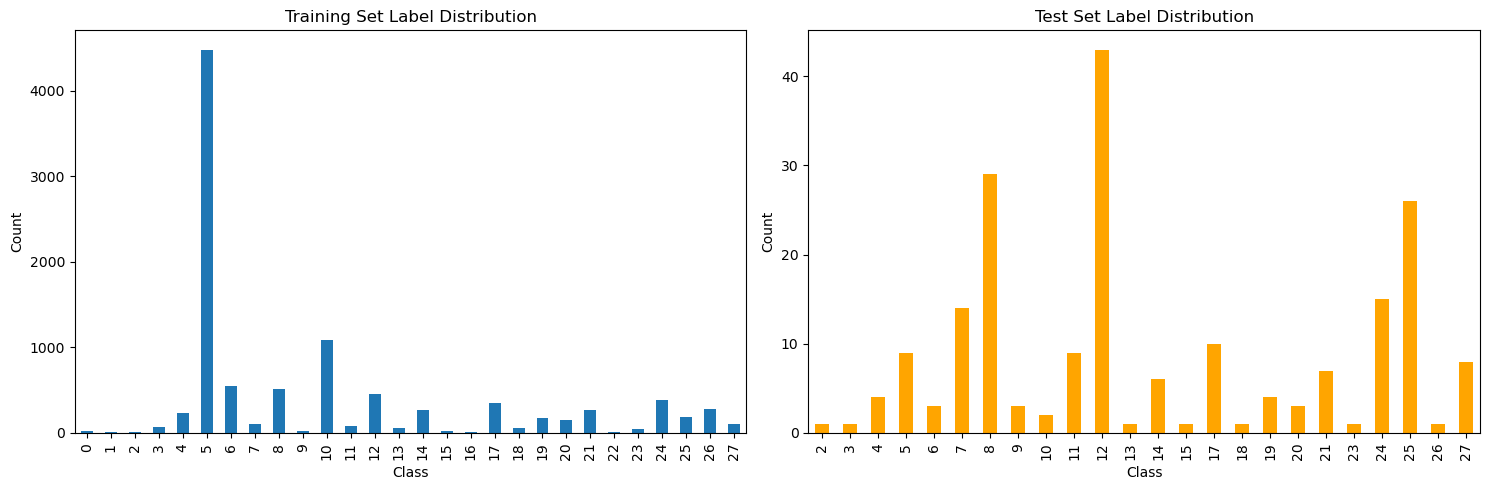

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')
X_test_1 = pd.read_csv('../data/X_test_1.csv')
X_test_2 = pd.read_csv('../data/X_test_2.csv')
y_test_2 = pd.read_csv('../data/y_test_2_reduced.csv')

plt.figure(figsize=(15, 5))

# 训练集标签分布
plt.subplot(1, 2, 1)
train_label_dist = y_train['label'].value_counts().sort_index()
train_label_dist.plot(kind='bar')
plt.title('Training Set Label Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# 测试集标签分布
plt.subplot(1, 2, 2)
test_label_dist = y_test_2['label'].value_counts().sort_index()
test_label_dist.plot(kind='bar', color='orange')
plt.title('Test Set Label Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Label shift, also known as prior shift, prior probability shift or target shift, is when P(Y) changes but P(X|Y) remains the same. You can think of this as the case when the output distribution changes but for a given output, the input distribution stays the same.  来自论文 Huyen Chip 的《Data Distribution Shifts and Monitoring》

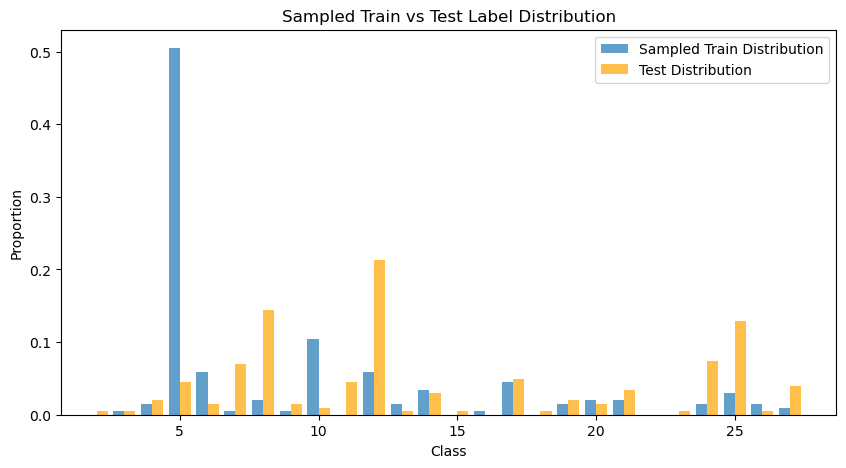

In [3]:
from sklearn.utils import resample

# 训练集和测试集的标签
train_labels = y_train['label'].values
test_labels = y_test_2['label'].values

# 从训练集中抽取与测试集相同数量的样本
sampled_train_labels = resample(train_labels, n_samples=len(test_labels), replace=False, random_state=42)

# 比较分布
sampled_train_dist = pd.Series(sampled_train_labels).value_counts(normalize=True).sort_index()
test_dist = pd.Series(test_labels).value_counts(normalize=True).sort_index()

# 可视化对比，调整颜色
plt.figure(figsize=(10, 5))
plt.bar(sampled_train_dist.index - 0.2, sampled_train_dist.values, width=0.4, label="Sampled Train Distribution", alpha=0.7)
plt.bar(test_dist.index + 0.2, test_dist.values, width=0.4, label="Test Distribution", alpha=0.7, color='orange')
plt.title('Sampled Train vs Test Label Distribution')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.legend()
plt.show()

以上 train_labels 中采样一次后的结果，并不代表训练集的 真实全貌。它的偏差可能是因为：

抽样方差导致的偶然失衡

类别较少时的极端偏移（比如 rare class 只抽到1个或0个）

并且我们还没有证明 P(X|Y) remains the same

综上 不能笃定 就是Label Shift 

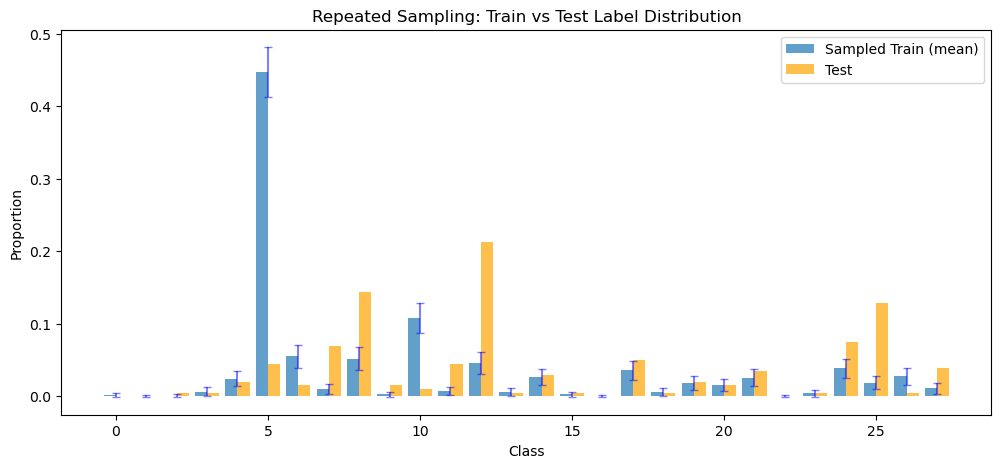

In [4]:
from sklearn.utils import resample
import numpy as np

n_trials = 1000
class_counts_list = []

for _ in range(n_trials):
    sampled = resample(train_labels, n_samples=len(test_labels), replace=False)
    sampled_dist = pd.Series(sampled).value_counts(normalize=True).sort_index()
    class_counts_list.append(sampled_dist)

# 合并为 DataFrame
sampled_df = pd.DataFrame(class_counts_list).fillna(0)
sampled_mean = sampled_df.mean()
sampled_std = sampled_df.std()

# 可视化
plt.figure(figsize=(12, 5))
plt.bar(sampled_mean.index - 0.2, sampled_mean.values, width=0.4, label="Sampled Train (mean)", alpha=0.7)
plt.bar(test_dist.index + 0.2, test_dist.values, width=0.4, label="Test", alpha=0.7, color='orange')
plt.errorbar(sampled_mean.index, sampled_mean.values, yerr=sampled_std.values, fmt='none', ecolor='blue', alpha=0.5, capsize=3)
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Repeated Sampling: Train vs Test Label Distribution')
plt.legend()
plt.show()




| 类别 | 训练集均值 (%) | 测试集比例 (%) | 偏移情况     | 问题类型                 | 建议处理方式                          |
|------|----------------|----------------|--------------|--------------------------|---------------------------------------|
| 5    | ≈ 44–46        | < 5            | ✅ 极端偏移   | 训练集中占比异常高       | 降采样 class 5 / 调低 class_weight    |
| 12   | ≈ 4–5          | ≈ 20–27        | ✅ 明显偏移   | 训练集严重低覆盖         | 上采样 / SMOTE / 数据增强            |
| 8    | ≈ 5–6          | ≈ 10–20        | ✅ 明显偏移   | 训练集中样本不足         | class_weight / 上采样 / 类别增强      |
| 25   | ≈ 2            | ≈ 10–17        | ✅ 明显偏移   | 测试集中占比高但训练稀疏 | 上采样 / class_weight                |
| 7    | ≈ 1            | ≈ 5–10         | ✅ 偏移       | 训练样本偏少             | 可考虑上采样或权重补偿               |
| 24   | ≈ 3–4          | ≈ 6–11         | ⚠️ 轻度偏移   | 可控偏移，测试略偏高     | 视模型性能决定是否处理               |
| 0, 1, 2, 16, 22 | ≈ 0–0.2        | ≈ 0            | ✅ 测试集中缺失 | 训练集存在但无用类       | 可考虑合并为“其他”或剔除             |
| 23   | ≈ 0            | ≈ 1            | ✅ 训练集中缺失 | 无法学习该类             | 可跳过训练或作为未知类处理           |


In [5]:
import numpy as np

def bootstrap_confidence_interval(data, num_samples=1000, alpha=0.05):
    """
    使用 Bootstrap 方法计算类别比例的置信区间
    """
    proportions = []
    for _ in range(num_samples):
        sample = np.random.choice(data, size=len(data), replace=True)
        prop = pd.Series(sample).value_counts(normalize=True).sort_index()
        proportions.append(prop)
    proportions = pd.DataFrame(proportions).fillna(0)
    lower_bound = proportions.quantile(alpha / 2)
    upper_bound = proportions.quantile(1 - alpha / 2)
    return lower_bound, upper_bound

# 计算置信区间
train_lower, train_upper = bootstrap_confidence_interval(train_labels)
test_lower, test_upper = bootstrap_confidence_interval(test_labels)



In [72]:
print("训练集类别比例的置信区间：")
pd.DataFrame({'Lower Bound': train_lower, 'Upper Bound': train_upper})


训练集类别比例的置信区间：


,Lower Bound,Upper Bound
0,0.001000,0.002600
1,0.000200,0.001300
2,0.000200,0.001200
3,0.005100,0.008002
4,0.021000,0.027000
5,0.438500,0.457105
6,0.050900,0.060100
7,0.008300,0.012300
8,0.047297,0.055800
9,0.001600,0.003500


In [71]:
print("\n测试集类别比例的置信区间：")
pd.DataFrame({'Lower Bound': test_lower, 'Upper Bound': test_upper})


测试集类别比例的置信区间：


,Lower Bound,Upper Bound
2,0.000000,0.014851
4,0.004950,0.039604
5,0.019802,0.074257
6,0.000000,0.034653
7,0.034653,0.108911
8,0.099010,0.188243
9,0.000000,0.034653
10,0.000000,0.024752
11,0.019802,0.074257
12,0.158416,0.267327


| 类别 | Train CI (%)     | Test CI (%)      | 是否偏移 | 问题类型            | 建议                           |
|------|------------------|------------------|----------|---------------------|--------------------------------|
| 5    | 43.8 – 45.8      | 2.0 – 7.4        | ✅ 严重偏移 | 训练集比例极高       | 降权训练样本 / 降采样 class 5 |
| 8    | 4.8 – 5.6        | 9.4 – 19.3       | ✅ 偏移     | 测试集中占比更高     | class_weight / SMOTE增强       |
| 12   | 4.2 – 5.0        | 15.8 – 27.2      | ✅ 偏移     | 训练集不足           | SMOTE / 数据增强 / 加权损失     |
| 25   | 1.6 – 2.1        | 8.4 – 17.8       | ✅ 偏移     | 训练集中极少         | 上采样 class 25 / class_weight  |
| 7    | 0.8 – 1.2        | 3.5 – 10.4       | ✅ 偏移     | 测试集中更常见       | 考虑上采样 / class_weight      |
| 24   | 3.5 – 4.2        | 4.0 – 11.4       | ⚠️ 轻度偏移 | 测试集中偏多         | 可选增强 / 视效果决定          |
| 4    | 2.1 – 2.7        | 0.5 – 4.0        | ⚠️ 轻度偏移 | 不稳定              | 观察模型表现决定是否处理        |
| 23   | ~0               | 0.0 – 1.5        | ✅ 测试独有 | 训练集中完全缺失     | 无法预测，需重新采样或忽略该类 |
| 0,1,2,16,22 | 非 0 | ≈ 0              | ✅ 偏移     | 训练集中出现但测试集中消失 | 可视为冗余类，考虑合并/剔除   |


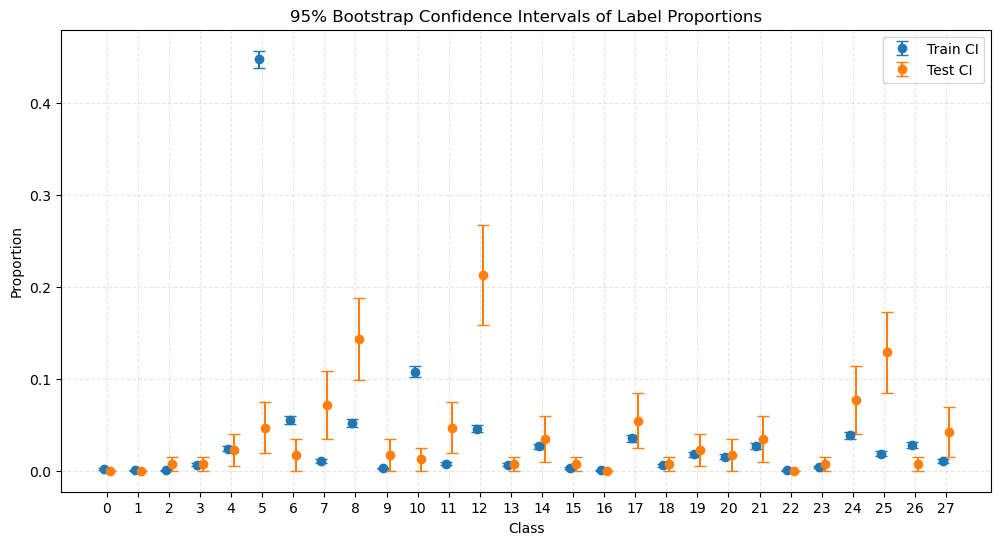

In [12]:
# Visualize Confidence Intervals
classes = sorted(set(train_lower.index).union(set(test_lower.index)))

train_mean = (train_lower + train_upper) / 2
train_err = (train_upper - train_lower) / 2

test_mean = (test_lower + test_upper) / 2
test_err = (test_upper - test_lower) / 2

x = np.arange(len(classes))

plt.figure(figsize=(12, 6))
plt.errorbar(x - 0.1, train_mean.reindex(classes, fill_value=0), yerr=train_err.reindex(classes, fill_value=0),
             fmt='o', capsize=4, label='Train CI')
plt.errorbar(x + 0.1, test_mean.reindex(classes, fill_value=0), yerr=test_err.reindex(classes, fill_value=0),
             fmt='o', capsize=4, label='Test CI')
plt.xticks(ticks=x, labels=classes)
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('95% Bootstrap Confidence Intervals of Label Proportions')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()



以上结果，我们可以确信P(Y)是变了的，但是P(X|Y) remains the same还未得证

### 初始尝试：使用 domain classifier 检测 shift

以下 我们选择了类别 8、12 和 25 进行详细的类条件分布分析，基于我们之前的实验结果。

这些类别在训练集和测试集之间表现出明显的标签分布变化（p(y)），这一点通过 bootstrap 置信区间分析得到了验证。

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

# 通用 per-class domain 可分性分析函数
def domain_auc_weighted_per_class(
    class_label, 
    X_train, y_train, 
    X_test, y_test, 
    model, 
    high_shift_features=None, 
    drop_features=False  # 默认不剔除
):
    X_train_class = X_train[y_train['label'] == class_label]
    X_test_class = X_test[y_test['label'] == class_label]

    n_train, n_test = len(X_train_class), len(X_test_class)
    if n_train < 5 or n_test < 5:
        return class_label, n_train, n_test, None

    # 剔除高漂移特征 Optional
    if drop_features and high_shift_features:
        X_train_class = X_train_class.drop(columns=high_shift_features, errors='ignore')
        X_test_class = X_test_class.drop(columns=high_shift_features, errors='ignore')

    # 拼接数据并训练 domain classifier
    X_combined = pd.concat([X_train_class, X_test_class])
    y_domain = np.array([0] * n_train + [1] * n_test)
    weights = np.array([1 / n_train] * n_train + [1 / n_test] * n_test)

    model.fit(X_combined, y_domain, sample_weight=weights)
    pred_probs = model.predict_proba(X_combined)[:, 1]
    auc = roc_auc_score(y_domain, pred_probs)

    return class_label, n_train, n_test, auc


对于每个特定类别8、12、25，提取其在训练集和测试集中的样本，并训练域分类器来判断这两部分是否可分。

若某一类别的训练样本与测试样本在特征空间中几乎可以完全区分（AUC 接近 1.0），则说明该类别的条件特征分布 p(x∣y) 已发生变化。

为了确保结果稳定，我们使用了三种模型（XGBoost、RF、LR）进行对比，并结合全局 domain classifier 选取了前 10 个高漂移特征。

In [ ]:
# 自动获取高漂移特征（全局 domain classifier）
def get_high_shift_features(X_train, X_test, n_top=10):
    X_combined = pd.concat([X_train, X_test], ignore_index=True)
    y_domain = [0] * len(X_train) + [1] * len(X_test)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_combined, y_domain)

    importances = clf.feature_importances_
    top_indices = np.argsort(importances)[::-1][:n_top]
    top_features = [X_combined.columns[i] for i in top_indices]
    return top_features

X_test_reduced = X_test_2.iloc[:202]
top_features = get_high_shift_features(X_train, X_test_reduced, n_top=10)
print("Top shifted features:", top_features)

# 定义三个模型
rf_model = RandomForestClassifier(random_state=42)

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

lr_model = LogisticRegression(max_iter=1000)

# 批量运行 per-class AUC 分析
def run_model_for_classes(model, model_name):
    results = []
    for cls in [8, 12, 25]:
        res = domain_auc_weighted_per_class(
            cls, X_train, y_train, X_test_reduced, y_test_2,
            model=model,
            high_shift_features=top_features,
            drop_features=False  # 默认不剔除特征
        )
        label, n_train, n_test, auc = res
        if auc is None:
            print(f"[{model_name}] Class {label}: Skipped (Train={n_train}, Test={n_test})")
        else:
            print(f"[{model_name}] Class {label}: AUC = {auc:.4f} (Train={n_train}, Test={n_test})")
        results.append((model_name, label, n_train, n_test, auc))
    return results

results_all = []
results_all += run_model_for_classes(rf_model, "RandomForest")
results_all += run_model_for_classes(xgb_model, "XGBoost")
results_all += run_model_for_classes(lr_model, "LogisticRegression")

df_results = pd.DataFrame(results_all, columns=["Model", "Class", "Train_Count", "Test_Count", "AUC"])
df_results


Top shifted features: ['214', '176', '242', '249', '5', '153', '267', '228', '255', '204']
[RandomForest] Class 8: AUC = 1.0000 (Train=516, Test=29)
[RandomForest] Class 12: AUC = 1.0000 (Train=457, Test=43)
[RandomForest] Class 25: AUC = 1.0000 (Train=184, Test=26)


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:16:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:16:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[XGBoost] Class 8: AUC = 0.5000 (Train=516, Test=29)
[XGBoost] Class 12: AUC = 0.5000 (Train=457, Test=43)
[XGBoost] Class 25: AUC = 0.5000 (Train=184, Test=26)
[LogisticRegression] Class 8: AUC = 0.9256 (Train=516, Test=29)
[LogisticRegression] Class 12: AUC = 0.9246 (Train=457, Test=43)
[LogisticRegression] Class 25: AUC = 0.9647 (Train=184, Test=26)


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:16:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Class,Train_Count,Test_Count,AUC
0,RandomForest,8,516,29,1.000000
1,RandomForest,12,457,43,1.000000
2,RandomForest,25,184,26,1.000000
3,XGBoost,8,516,29,0.500000
4,XGBoost,12,457,43,0.500000
5,XGBoost,25,184,26,0.500000
6,LogisticRegression,8,516,29,0.925555
7,LogisticRegression,12,457,43,0.924635
8,LogisticRegression,25,184,26,0.964674


结果显示，Random Forest 在所有类上的 AUC 达到 1.0，表明训练集与测试集在特征空间中完全可分，说明条件分布 `p(x|y)` 发生了显著变化。

Logistic Regression 在相同任务下也取得了较高 AUC（约 0.92–0.96），说明在低维线性空间下，训练与测试的样本仍存在明显可分性。这进一步佐证了 class-conditional covariate shift 的存在。

相比之下，XGBoost 在所有类上 AUC 均为 0.500，表现为随机猜测。我们推测这是由于默认参数配置下，XGBoost 未能有效拟合该类下的微弱分布差异，或者该模型在剔除关键特征后欠拟合。

这一结果也从侧面反映出我们识别出的高漂移特征确实主导了 domain 区分性，而分布差异在多个模型下均可观测，具有一致性验证价值。


### 精细验证策略：引入 PCA + KDE + Wasserstein 方法

虽然 domain classifier 已经从可分性角度揭示了 `p(x|y)` 的差异，但我们希望从更直观且可量化的分布层面验证这一现象是否真实存在。因此，我们进一步引入了 PCA + KDE + Wasserstein 方法，从特征空间的概率分布角度直接比较条件分布 `p(x|y)` 是否发生变化。

为了更直接地从“分布角度”验证 p(x|y) 是否变化，我们设计了如下流程：

按类划分，仅分析每个标签下的样本；
PCA 降维，统一投影到共享低维空间，保留 ≥95% 总变异，确保信息足够；
标准化处理，避免原始特征尺度差异影响分析；
核密度估计（KDE），估计降维后的特征分布 p(z∣y)；
Wasserstein 距离，衡量 train/test 条件分布差异的强度。

#### 为什么要进行 PCA 降维？

我们的原始特征维度为 300，如果直接在原空间中进行分布估计（如 KDE）或比较（如 Wasserstein/MMD），会面临如下问题：

| 问题类型 | 原因 |
|----------|------|
| 高维下 KDE / Wasserstein 不稳定 | 高维空间中的数据非常稀疏，核密度估计不准确，容易导致方差爆炸，出现伪结论 |
| 分布差异可能集中在低维方向 | 某些主成分承载了大部分有意义的信息，而其余维度可能只是噪声 |
| 人类难以解释和可视化 | 高维特征空间不可视化，不利于分析和展示；降维后更直观且便于绘图说明 |


#### 为什么选择“累计解释方差 ≥ 95% 的前 k 个主成分”？

PCA 会根据特征变化的大小将主成分排序：

- 第 1 主成分解释最多的信息（最大方向的变异）；
- 第 2 主成分次之；
- 后续主成分则贡献较小，很多只是噪声。

我们采取的策略是：**只保留累计方差贡献率 ≥ 95% 的前  k  个主成分**。

| 优势 | 解释 |
|------|------|
| 最大限度保留原始信息结构 | 避免信息丢失，保留大部分变化方向 |
| 剔除低方差维度 | 过滤噪声，提高分布估计的准确性 |
| 提高统计方法的稳定性 | 降低维度后，Wasserstein 距离、KDE、MMD 等估计更可靠 |
| 降低计算复杂度 | 从 300 维压缩到几十维，提升效率 |
| 支持可视化分析 | 可以更清楚展示降维后的类间差异和 shift 情况 |


In [52]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde, wasserstein_distance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 找到累计方差 ≥ 95% 的前 k 个主成分 
# 自动选择保留 >=95% 变异的主成分数
def get_k_for_variance(pca, threshold=0.95):
    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    return np.argmax(cumulative >= threshold) + 1

# 对某个 class 执行完整流程
def compare_pca_density(class_label, var_threshold=0.95):
    X_train_class = X_train[y_train['label'] == class_label]
    X_test_class = X_test_2.iloc[:202][y_test_2['label'] == class_label]

    n_train, n_test = len(X_train_class), len(X_test_class)
    if n_train < 5 or n_test < 5:
        return class_label, n_train, n_test, None, None, None

    X_combined = pd.concat([X_train_class, X_test_class])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)


    # PCA
    pca = PCA(n_components=None)
    Z_all = pca.fit_transform(X_scaled)
    k = get_k_for_variance(pca, threshold=var_threshold)

    Z_train = Z_all[:n_train, :k]
    Z_test = Z_all[n_train:, :k]

    # 只在主成分 1 上做 KDE + Wasserstein（可扩展到更多维度）
    z1_train = Z_train[:, 0]
    z1_test = Z_test[:, 0]

    kde_train = gaussian_kde(z1_train)
    kde_test = gaussian_kde(z1_test)

    z_range = np.linspace(min(z1_train.min(), z1_test.min()), max(z1_train.max(), z1_test.max()), 200)
    density_diff = np.abs(kde_train(z_range) - kde_test(z_range)).mean()
    wasser_dist = wasserstein_distance(z1_train, z1_test)

    return class_label, n_train, n_test, k, density_diff, wasser_dist


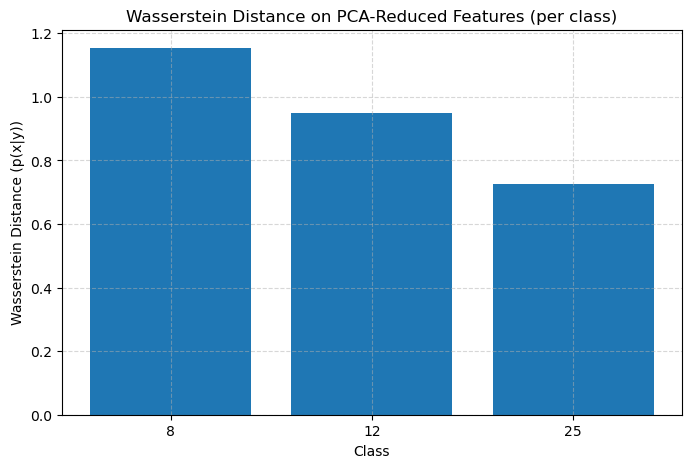

,Class,Train_Count,Test_Count,PCA_Dims,Density_Diff,Wasserstein_Dist
0,4,238,4,NaN,NaN,NaN
1,8,516,29,128.0,0.009426,1.153721
2,12,457,43,131.0,0.005809,0.949188
3,25,184,26,94.0,0.003661,0.725165


In [74]:
results = []

# 指定你想分析的类
for cls in [4, 8, 12, 25]:
    res = compare_pca_density(cls)
    results.append(res)

df_results = pd.DataFrame(results, columns=[
    'Class', 'Train_Count', 'Test_Count', 'PCA_Dims', 'Density_Diff', 'Wasserstein_Dist'
])


df_plot = df_results.dropna()
plt.figure(figsize=(8, 5))
plt.bar(df_plot['Class'].astype(str), df_plot['Wasserstein_Dist'])
plt.title("Wasserstein Distance on PCA-Reduced Features (per class)")
plt.xlabel("Class")
plt.ylabel("Wasserstein Distance (p(x|y))")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

df_results



即使在 PCA 降维后的特征空间中，训练集和测试集在同一标签下的特征分布也存在显著差异，p(x|y) 没有保持不变。

所以这不是 label shift，

根据 Kouw & Loog (2019) — 《A Review of Domain Adaptation without Target Labels》 Class-conditional covariate shift occurs when p(x∣y) changes between domains

这可以算做 Class-conditional covariate shift

| 类型            | 形式                            | 官方文章是否提到 |
|-----------------|----------------------------------|----------------|
| Covariate Shift |  p(x)  变， p(y\|x)  不变 | 有提到       |
| Label Shift     |  p(y)  变， p(x\|y)  不变 | 有提到       |
| Concept Shift   |  p(y\|x)  变（决策边界变化）  | 有提到       |
| Class-Conditional Covariate Shift |  p(x\|y)  变， p(y)  可能也变 | 未提及   |


下一步 我们探索是否是covariate shift

定义是p(x) 变了,但 p(y∣x) 保持不变

也就是 如果在源域上训练出一个模型 f(x)≈p(y∣x)，

它在目标域上应该仍然适用，因为 p(y∣x) 是一样的。

如何验证？

- 使用多个模型训练：为了控制模型复杂度带来的影响，排除模型不行的因素，我们选用上面用到的三个模型， 

- 仅在源域 Dtrain 上训练，直接在目标域 Dtest2 上测试：保证模型只学习源域的 \( p(y|x) \)，观察泛化能力是否维持

如果目标域上表现良好，则说明 \( p(y|x) \) 没有变化  满足 Covariate Shift  
如果目标域上表现大幅下降，说明 \( p(y|x) \) 变化，不满足 Covariate Shift 


In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, accuracy_score, f1_score

# 所有模型
models = {
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    ),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000)
}

results = []

for name, model in models.items():
    print(f"\n{name}")

    # 训练模型
    model.fit(X_train, y_train['label'])

    # Train 域
    train_preds = model.predict(X_train)
    train_acc = accuracy_score(y_train['label'], train_preds)
    train_f1 = f1_score(y_train['label'], train_preds, average='macro')

    # Test 域
    test_preds = model.predict(X_test_reduced)
    test_acc = accuracy_score(y_test_2['label'], test_preds)
    test_f1 = f1_score(y_test_2['label'], test_preds, average='macro')

    results.append((name, train_acc, train_f1, test_acc, test_f1))



XGBoost


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:21:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



RandomForest

LogisticRegression


In [86]:
import pandas as pd

df = pd.DataFrame(results, columns=["Model", "Train_Acc", "Train_F1", "Test_Acc", "Test_F1"])
df


,Model,Train_Acc,Train_F1,Test_Acc,Test_F1
0,XGBoost,0.9634,0.961096,0.574257,0.373625
1,RandomForest,1.0000,1.000000,0.376238,0.227364
2,LogisticRegression,0.9311,0.923767,0.554455,0.383930


**源域性能**：三个模型（XGBoost, RF, LR）在训练集上 F1-score 均高于 0.92，说明它们成功学习到了源域的 \( p(y|x) \)。

**目标域泛化能力**：
- 所有模型在 Dtest2 上 F1-score 降至 0.37~0.38，性能崩溃。

- 且非个别模型现象，三个结构不同的模型均出现大幅退化。

- 明确排除了模型欠拟合或过拟合的单一原因。

为了进一步观察错分类的label和验证上述实验结果，我们引入混淆矩阵

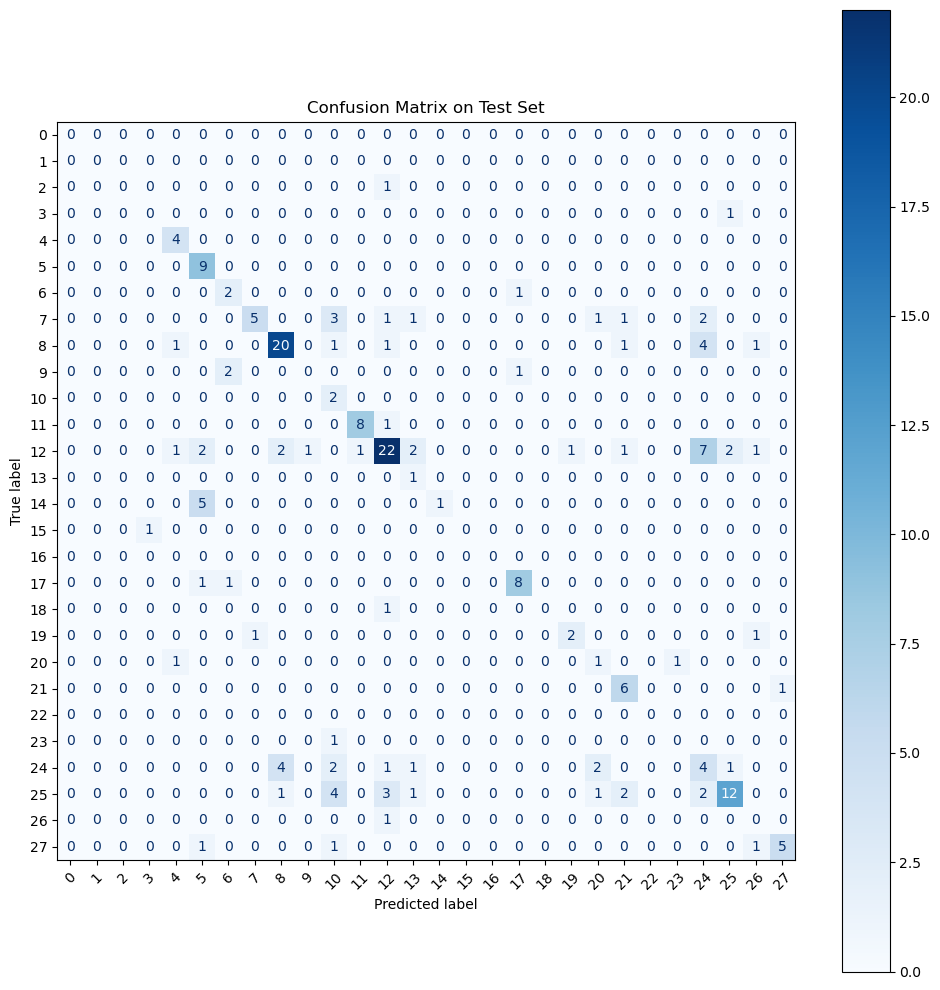

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 假设 test_preds 和 y_test_2['label'] 已有
cm = confusion_matrix(y_test_2['label'], test_preds, labels=sorted(y_train['label'].unique()))

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_train['label'].unique()))
disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()


从混淆矩阵中可以看出，部分类别12、8、25仍能被正确识别，但也存在如 14、15、23、0、18被完全误分类或模型无法识别。这表明模型训练得到的决策函数 \( p(y|x) \) 在测试集上严重失效。

此外，一些类别之间存在严重混淆，如类 24 和 25 被频繁误判为彼此，这进一步提示了类别边界在特征空间中的模糊化。

这些现象均表明：模型在测试域上不能泛化，训练集与测试集之间的特征条件分布 \( p(x|y) \) 和决策边界 \( p(y|x) \) 均发生变化。因此，我们将此 shift 类型归类为 **class-conditional covariate shift + concept shift** 的混合形式。
